<a href="https://colab.research.google.com/github/SeptiLutfiana/MESIN-LEARNING/blob/main/Pertemuan10_Praktikum1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

RNN untuk Analisis Sentimen

In [2]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [4]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [5]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [6]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


Berikutnya acak data untuk pelatihan dan membuat kumpulan pasangan (teks, label) ini:

In [7]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])


texts:  [b'This movie is about human relationships. Charming, funny, and well written, with meaningful text. It seems that Morgan Freeman surely have fun at the set. Also good music. Paz Vega is a beautiful and smart woman. I really enjoy her acting. Woman like her are a good motivation to learn Spanish language. From the moment Morgan Freeman meets the cute Paz Vega the view is taken on an intimate journey with two strangers learning to care about where their lives are headed. 10 Items or Less is about zest of life. If you enjoy this film see also The Pursuit of Happiness with Will Smith and his son. Thats not a action film or a nude comedy. Its all about human relations.'
 b'I was always curious about this film because it is so tough to find, so when I stumbled upon it on Ebay I forked over the $10 and bought it, now I understand why its so rare! This film is SO bad, so terribly written and hopelessly low budget that the ending credits, which show all of the cut scenes where they fum

**Buat Teks Encoder**

Teks mentah yang dimuat oleh tfds perlu diproses sebelum dapat digunakan dalam model. Cara termudah memproses teks untuk pelatihan adalah menggunakan lapisan TextVectorization. Lapisan ini memiliki banyak kemampuan, namun pada tutorial ini menggunakan perilaku default. Buat lapisan tersebut, dan teruskan teks kumpulan data ke metode .adapt lapisan:

In [8]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

Metode .adapt mengatur kosakata lapisan. 20 token pertama dapat dilihat dengan kode berikut. Setelah padding dan token yang tidak diketahui, mereka diurutkan berdasarkan frekuensi:

In [10]:
vocab=np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

Setelah kosakata diatur, lapisan dapat mengkodekan teks ke dalam indeks. Tensor indeks diberi bantalan 0 ke urutan terpanjang dalam batch (kecuali jika Anda menetapkan output_sequence_length tetap):

In [12]:
encoded_example=encoder(example)[:3].numpy()
encoded_example

array([[ 11,  18,   7, ...,   0,   0,   0],
       [ 10,  14, 203, ...,   0,   0,   0],
       [330, 347,  33, ...,   0,   0,   0]])

In [13]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'This movie is about human relationships. Charming, funny, and well written, with meaningful text. It seems that Morgan Freeman surely have fun at the set. Also good music. Paz Vega is a beautiful and smart woman. I really enjoy her acting. Woman like her are a good motivation to learn Spanish language. From the moment Morgan Freeman meets the cute Paz Vega the view is taken on an intimate journey with two strangers learning to care about where their lives are headed. 10 Items or Less is about zest of life. If you enjoy this film see also The Pursuit of Happiness with Will Smith and his son. Thats not a action film or a nude comedy. Its all about human relations.'
Round-trip:  this movie is about human [UNK] [UNK] funny and well written with [UNK] [UNK] it seems that [UNK] [UNK] [UNK] have fun at the set also good music [UNK] [UNK] is a beautiful and [UNK] woman i really enjoy her acting woman like her are a good [UNK] to learn [UNK] [UNK] from the moment [UNK] [UNK] meets 

**Buat Model**

In [14]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [16]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [17]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 8s 8s/step
[-0.02723554]


In [18]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 0s 20ms/step
[-0.02723554]


In [19]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 83ms/step
[-0.02723554]


In [20]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

**Train Model**

In [21]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 51s 107ms/step - loss: 0.6430 - accuracy: 0.5642 - val_loss: 0.4784 - val_accuracy: 0.7651
Epoch 2/10
391/391 [==============================] - 29s 73ms/step - loss: 0.4725 - accuracy: 0.7565 - val_loss: 0.4126 - val_accuracy: 0.8109
Epoch 3/10
391/391 [==============================] - 25s 64ms/step - loss: 0.3767 - accuracy: 0.8307 - val_loss: 0.3627 - val_accuracy: 0.8391
Epoch 4/10
391/391 [==============================] - 24s 62ms/step - loss: 0.3388 - accuracy: 0.8526 - val_loss: 0.3473 - val_accuracy: 0.8396
Epoch 5/10
391/391 [==============================] - 24s 61ms/step - loss: 0.3228 - accuracy: 0.8618 - val_loss: 0.3387 - val_accuracy: 0.8396
Epoch 6/10
391/391 [==============================] - 24s 62ms/step - loss: 0.3114 - accuracy: 0.8661 - val_loss: 0.3284 - val_accuracy: 0.8578
Epoch 7/10
391/391 [==============================] - 23s 59ms/step - loss: 0.3065 - accuracy: 0.8698 - val_loss: 0.3250 - val_accuracy

In [22]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 14s 35ms/step - loss: 0.3175 - accuracy: 0.8563
Test Loss: 0.31748083233833313
Test Accuracy: 0.8562800288200378


(0.0, 0.6603351399302483)

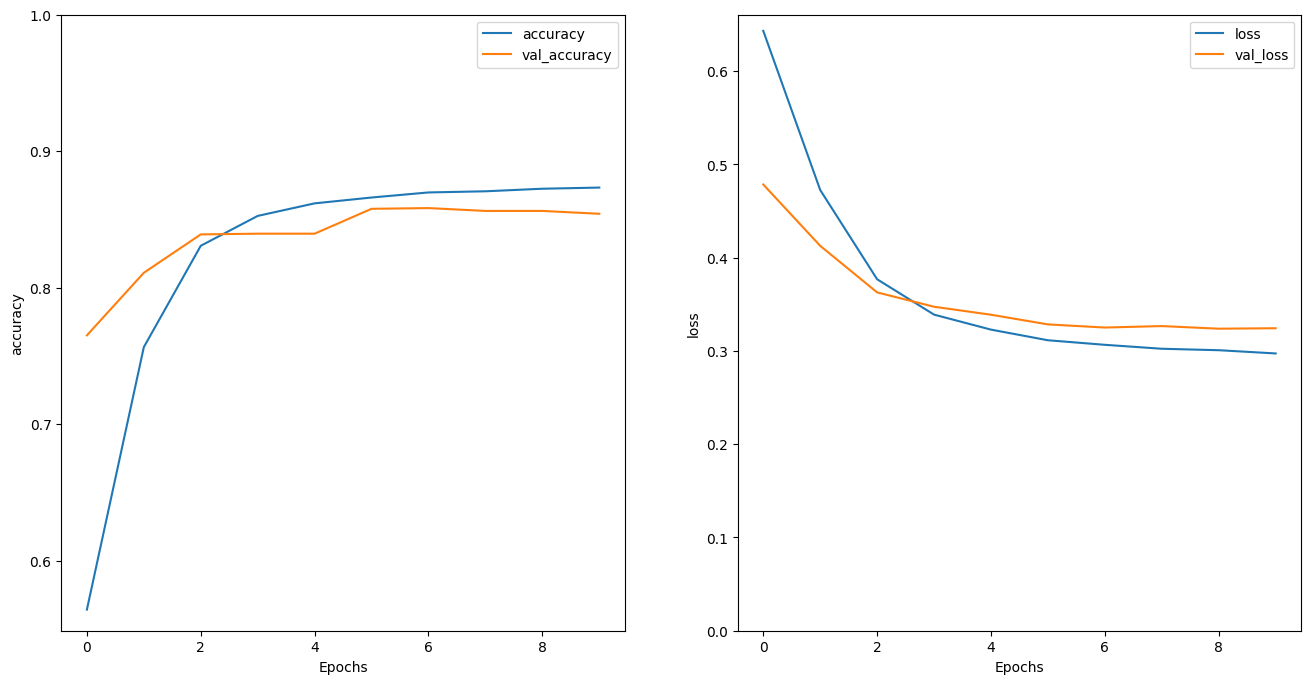

In [23]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [24]:
sample_text = ('The movie was cool. The animation and the graphics '
'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

1/1 [==============================] - 2s 2s/step


Hal yang menarik dari penggunaan RNN dengan return_sequences=True adalah outputnya masih memiliki 3 axis, sama seperti inputnya, sehingga bisa diteruskan ke layer RNN lain, seperti ini:

In [25]:
model = tf.keras.Sequential([
encoder,
tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
tf.keras.layers.Dense(64, activation='relu'),
tf.keras.layers.Dropout(0.5),
tf.keras.layers.Dense(1)
])

In [26]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
optimizer=tf.keras.optimizers.Adam(1e-4),
metrics=['accuracy'])

In [27]:
history = model.fit(train_dataset, epochs=10,
validation_data=test_dataset,
validation_steps=30)

Epoch 1/10
391/391 [==============================] - 77s 150ms/step - loss: 0.6339 - accuracy: 0.5717 - val_loss: 0.4466 - val_accuracy: 0.7979
Epoch 2/10
391/391 [==============================] - 47s 119ms/step - loss: 0.3964 - accuracy: 0.8244 - val_loss: 0.3698 - val_accuracy: 0.8318
Epoch 3/10
391/391 [==============================] - 46s 117ms/step - loss: 0.3430 - accuracy: 0.8532 - val_loss: 0.3440 - val_accuracy: 0.8448
Epoch 4/10
391/391 [==============================] - 45s 115ms/step - loss: 0.3317 - accuracy: 0.8586 - val_loss: 0.3366 - val_accuracy: 0.8417
Epoch 5/10
391/391 [==============================] - 48s 122ms/step - loss: 0.3178 - accuracy: 0.8638 - val_loss: 0.3290 - val_accuracy: 0.8578
Epoch 6/10
391/391 [==============================] - 45s 114ms/step - loss: 0.3135 - accuracy: 0.8638 - val_loss: 0.3278 - val_accuracy: 0.8568
Epoch 7/10
391/391 [==============================] - 45s 115ms/step - loss: 0.3072 - accuracy: 0.8677 - val_loss: 0.3326 - val_ac